# Analyzing PBMCs single-cell data with TopOMetry


For the manuscript

In [16]:
# Install pre-requisites and dbmap (for comparisons)
!pip install nmslib annoy scipy scanpy numba kneed pymde python-igraph leidenalg dbmap

In [2]:
# Install pre-release of TopOMetry
!pip install -i https://test.pypi.org/simple/ topo

Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 102kB 2.7MB/s 


In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import dbmap as dm
import topo as tp

None
None


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [6]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, dpi_save=800, facecolor='white', format='tif')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.9.1


## Analyzing ~33,000 PBMCs

### Load data and QC

In [5]:
!mkdir data
!wget https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc33k/pbmc33k_filtered_gene_bc_matrices.tar.gz -O data/pbmc33k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc33k_filtered_gene_bc_matrices.tar.gz
!mkdir write

--2021-04-18 19:59:20--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc33k/pbmc33k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83082472 (79M) [application/x-tar]
Saving to: ‘data/pbmc33k_filtered_gene_bc_matrices.tar.gz’

data/pbmc33k_filter 100%[===================>]  79.23M  22.5MB/s    in 3.7s    

2021-04-18 19:59:24 (21.4 MB/s) - ‘data/pbmc33k_filtered_gene_bc_matrices.tar.gz’ saved [83082472/83082472]



In [7]:
results_file = 'write/pbmc33k.h5ad'  # the file that will store the analysis results

In [8]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  
    var_names='gene_symbols',               
    cache=True)          
adata.var_names_make_unique()
adata                    

... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 33148 × 32738
    var: 'gene_ids'

In [9]:
# Default QC
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata

filtered out 7 cells that have less than 200 genes expressed
filtered out 14795 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 33141 × 17943
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Default workflow

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


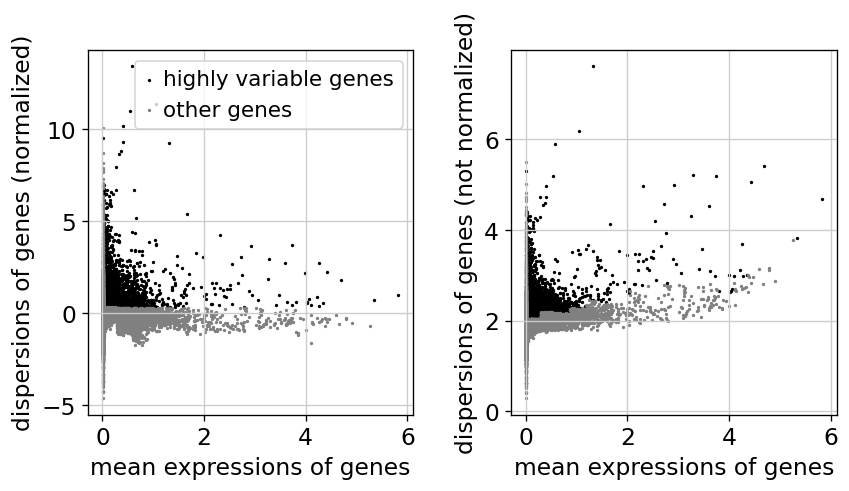

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=8, min_disp=0.3)
sc.pl.highly_variable_genes(adata)

In [11]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 33141 × 3322
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:46)


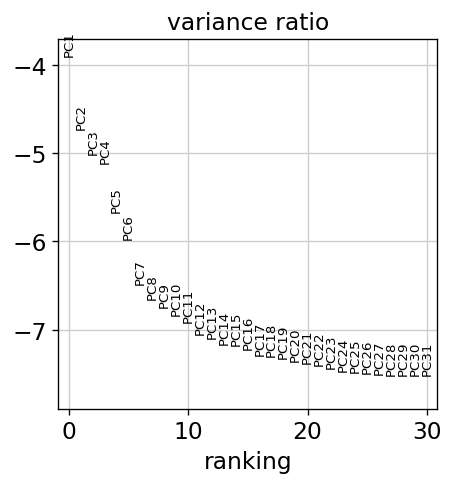

In [12]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True, save='_PCA_log_variance_ratio')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:44)


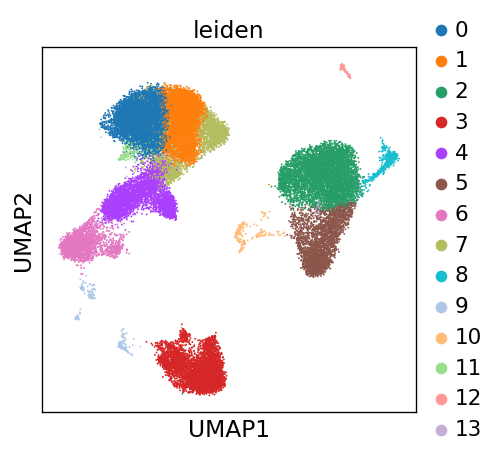

In [17]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.embedding(adata, basis='umap', color=['leiden'], size=5)

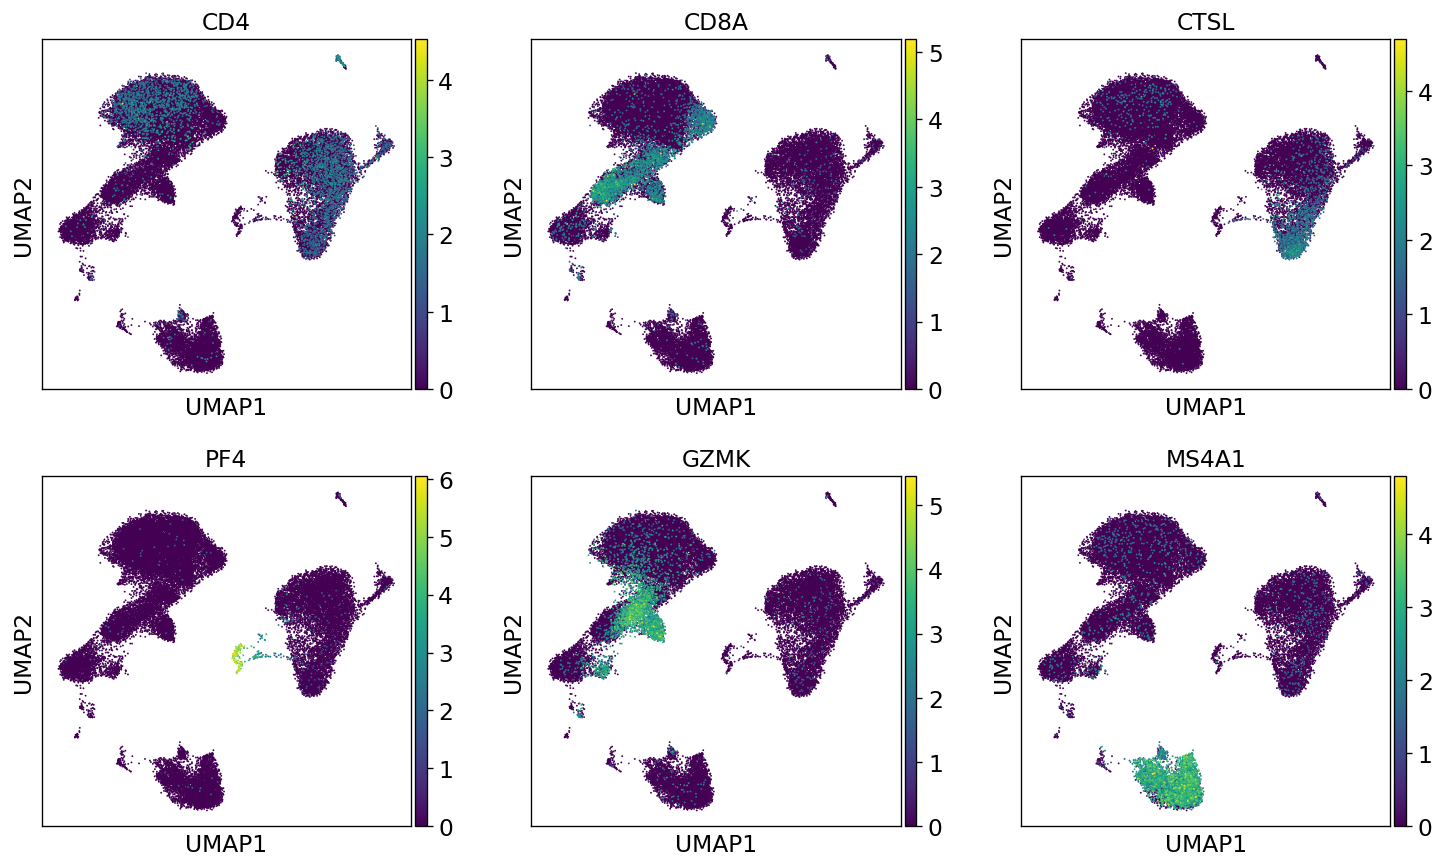

In [18]:
sc.pl.embedding(adata, basis='umap', color=['CD4', 'CD8A', 'CTSL', 'PF4', 'GZMK', 'MS4A1'], size=5, ncols=3)

### Topological analysis with TopOMetry

In [19]:
adata.write_h5ad(results_file)
adata = sc.read_h5ad(results_file)
adata

AnnData object with n_obs × n_vars = 33141 × 3322
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Building topological basis...


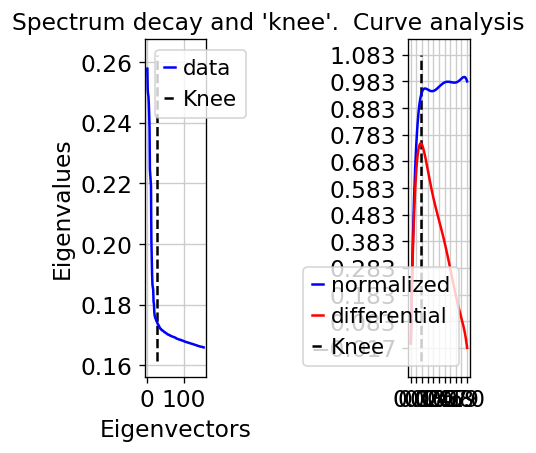

Diffusion fitted in = 1734.929031 (sec)
Building diffusion graph...
Topological graphs extracted in = 65.527704 (sec)


In [20]:
# Fit topological model
tg = tp.models.TopoGraph(n_jobs=10, n_eigs=150,
  		  plot_spectrum=True
  		  ).fit(adata.X)
dgraph, dtgraph = tg.transform()

In [25]:
# Rescale to 50 components
tg.MSDiffMap = tg.DiffBasis.rescale(n_eigs=150)

adata.obsm['X_db'] = tg.MSDiffMap

In [46]:
# Layout optimization
embdt, aux = tp.models.MAP(tg.MSDiffMap, dtgraph, min_dist=0.3, spread=2, n_epochs=600)

adata.obsm['X_db_dtMAP'] = embdt

Fuzzy layout optimization embedding in = 44.389385 (sec)


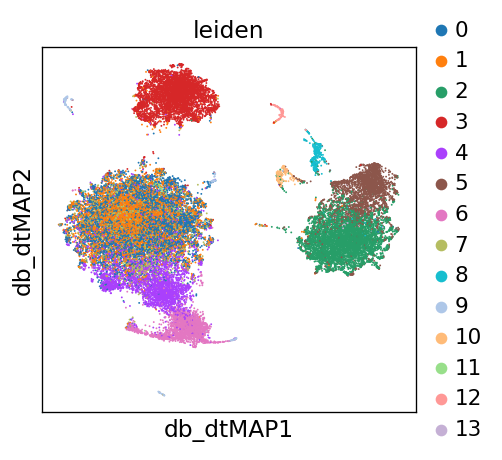

In [47]:
sc.pl.embedding(adata, basis='db_dtMAP', color=['leiden'], edges=False, size=5)

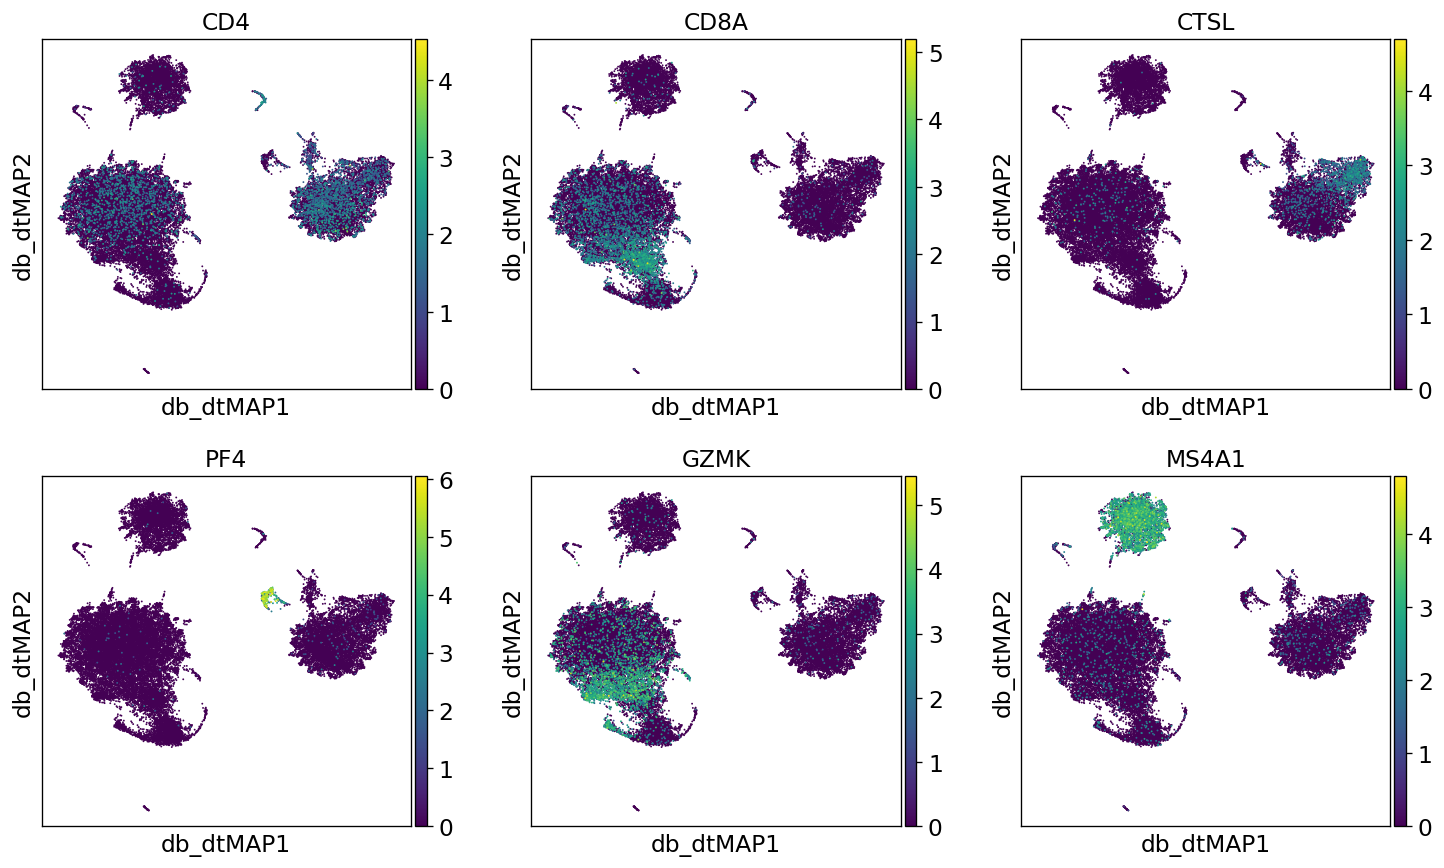

In [43]:
sc.pl.embedding(adata, basis='db_dtMAP', color=['CD4', 'CD8A', 'CTSL', 'PF4', 'GZMK', 'MS4A1'], size=5, ncols=3)

In [44]:
# We can also optimize the layout using the vanilla UMAP approach
import umap
db_umap_emb = umap.UMAP(min_dist=0.3, n_epochs=600).fit_transform(tg.MSDiffMap)
adata.obsm['X_db_UMAP'] = db_umap_emb

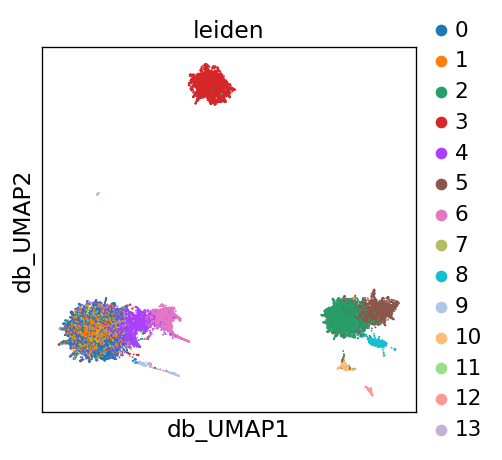

In [45]:
sc.pl.embedding(adata, basis='db_UMAP', color=['leiden'], edges=False, size=5)

## Using pyMDE for minimum-distortion embeddings of the topological graphs


In [48]:
import pymde

Apr 18 09:44:29 PM: Computing 15-nearest neighbors, with max_distance=None
Sun Apr 18 21:44:30 2021 Building RP forest with 18 trees
Sun Apr 18 21:44:31 2021 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	Stopping threshold met -- exiting after 6 iterations
Apr 18 09:44:36 PM: Computing quadratic initialization.
Apr 18 09:45:31 PM: Fitting a centered embedding into R^2, for a graph with 33141 items and 913918 edges.
Apr 18 09:45:31 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Apr 18 09:45:31 PM: iteration 000 | distortion 1.586110 | residual norm 2.44895 | step length 0.00310821 | percent change 0.00295687
Apr 18 09:45:38 PM: iteration 030 | distortion 0.283906 | residual norm 0.00249407 | step length 1 | percent change 1.2377
Apr 18 09:45:46 PM: iteration 060 | distortion 0.223668 | residual norm 0.00123309 | step length 1 | percent change 0.635365
Apr 18 09:45:53 PM: iteration 090 | distortion 0.208214 | res

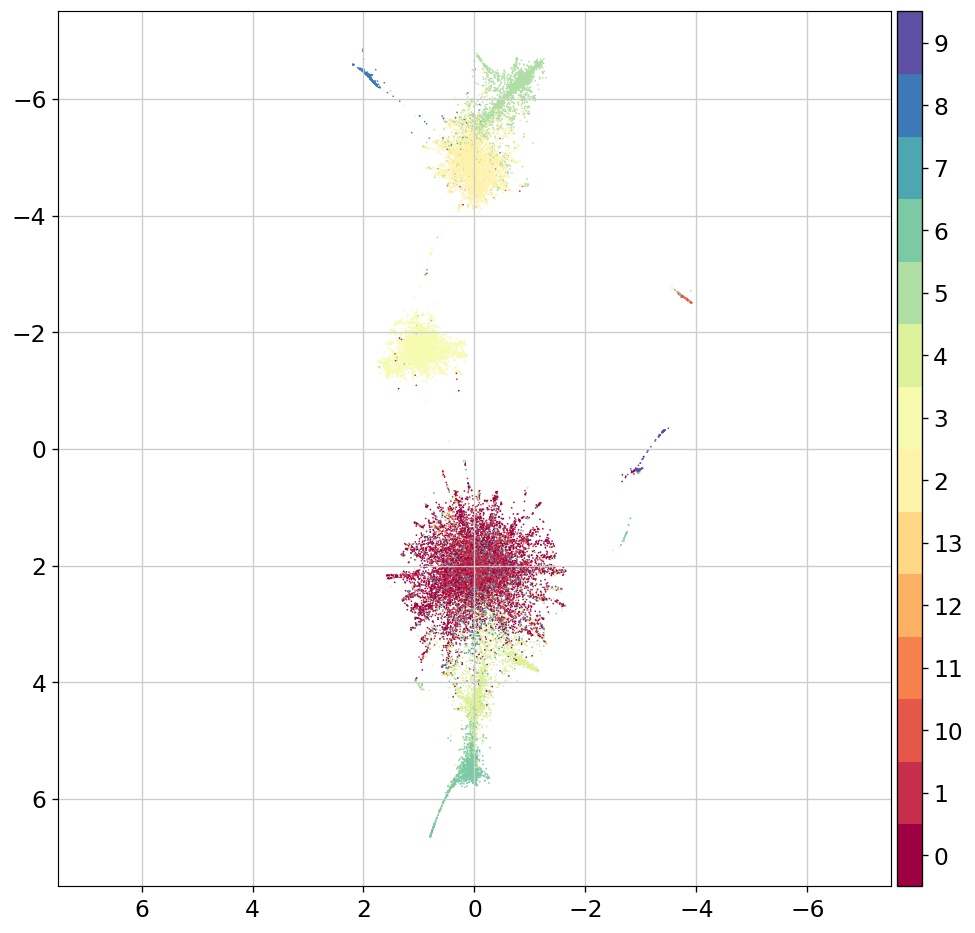

In [52]:
# First a neighborhood preserving embedding on the diffusion basis
nbr_mde = pymde.preserve_neighbors(tg.MSDiffMap, verbose=True)
nbr_embedding = nbr_mde.embed(verbose=True)
pymde.plot(nbr_embedding, color_by=adata.obs['leiden'], axis_limits=(7.5,-7.5))

In [ ]:
# Now preserving distances
dist_mde = pymde.preserve_distances(tg.MSDiffMap, verbose=True)
dist_embedding = dist_mde.embed()
pymde.plot(dist_embedding, color_by=adata.obs['leiden'], axis_limits=(10,-10))

Apr 18 09:49:56 PM: Sampling 50000000 edges
Apr 18 09:50:03 PM: Computing 50000000 distances
